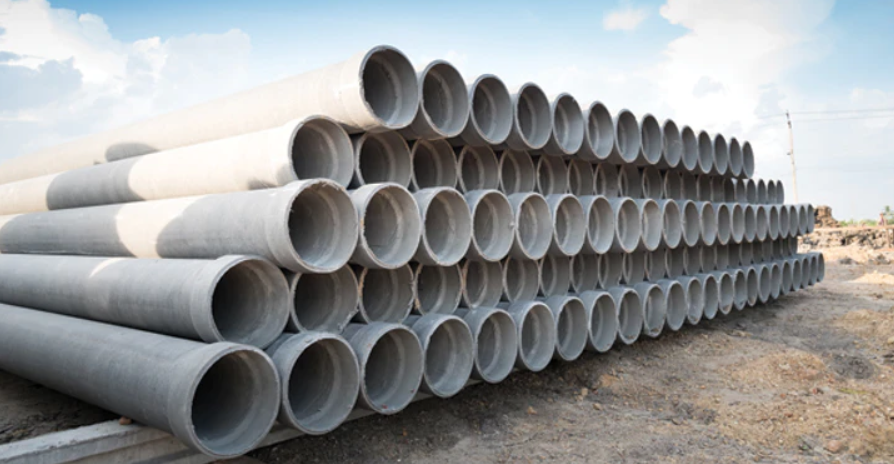

**About the dataset**

Surface Crack Detection Dataset

**Context**

Concrete surface cracks are major defect in civil structures. Such structures should be inspected regularly to evaluate the rigidity and tensile strength of the structure. Health and safety issues, environmental concerns as well as financial implications arise from the failure of concrete structures in many fields, including the oil and gas industry.

**Content**

The dataset contains images of various concrete surfaces with and without crack. Each class contains 20000 images (total of 40000 images), each 227 x 227 pixels with RGB channels. The dataset is generated from 458 high-resolution images (4032x3024 pixels) with the method proposed by Zhang et al (2016). High resolution images are found out to have high variance in terms of surface finish and illumination condition. 

**About this notebook**

The aim of this notebook is to train a binary classifier using a convolutional neural network (via Tensorflow).
The original data set is split into train and validation sets (38000 images), while a test set (2000 images) is also created to evaluate the performance of the model. This is a balanced dataset (i.e. approximately equal amounts of both classes are present) and therefore no class weight are introduced.

The data are augmented in terms of random rotation, flipping and tilting to significantly increase the diversity of data available for training, without actually collecting new data. This technique helps us avoid overfitting too. 

The neural network model consists of a 3-block VGG-style architecture where each block has a single convolutional and pooling layer using the Keras package. 
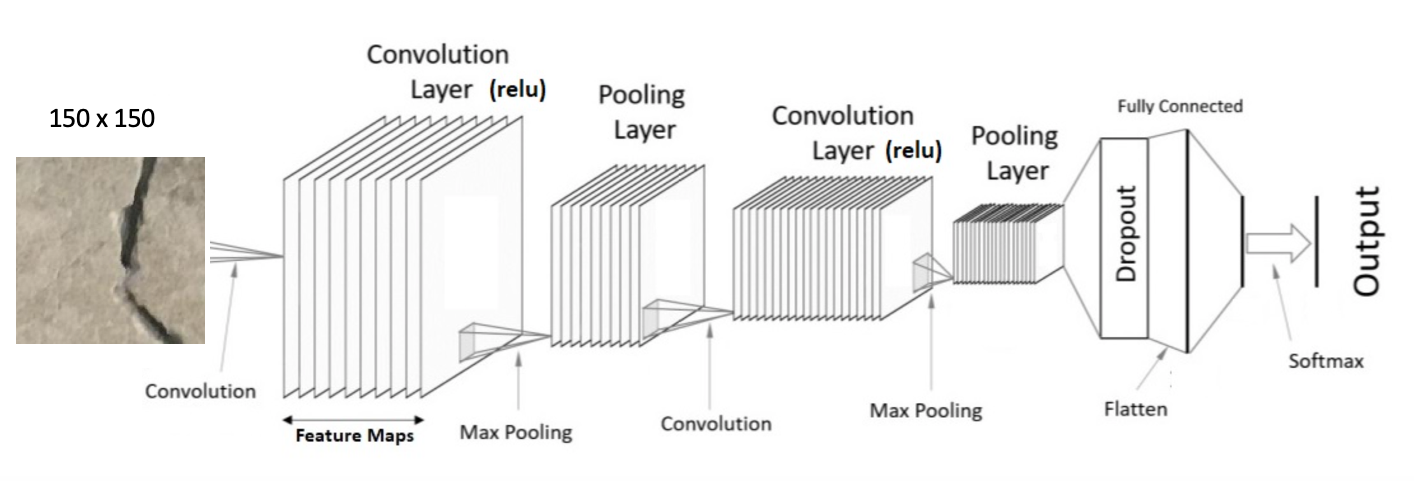

The features to be captured from convolutional layer increased from 64 to 128 because as suggested in literature,  such hierarchical structure performs better for a deep neural network.
Each convolutional layer has an activation function. Relu and Softmax activation functions are used which are reportedly common for classification problems.
The optimiser selected is 'Adam' and the loss function is sparse categorical crossentropy for classification.
Adam is one of the most effective optimizers for  neural networks, has relatively low memory requirements, and often requires little tuning of hyperparameters.

The model is evaluated using a test set, and various metrics are presented. 

**Acknowledgements**

This dataset is taken from the website Mendeley Data - Crack Detection, contributed by Çağlar Fırat Özgenel.

Özgenel, Çağlar Fırat (2019), “Concrete Crack Images for Classification”, Mendeley Data, v2
http://dx.doi.org/10.17632/5y9wdsg2zt.2
Previous works

2018 – Özgenel, Ç.F., Gönenç Sorguç, A. “Performance Comparison of Pretrained Convolutional Neural Networks on Crack Detection in Buildings”, ISARC 2018, Berlin.

Lei Zhang , Fan Yang , Yimin Daniel Zhang, and Y. J. Z., Zhang, L., Yang, F., Zhang, Y. D., & Zhu, Y. J. (2016). Road Crack Detection Using Deep Convolutional Neural Network. In 2016 IEEE International Conference on Image Processing (ICIP). http://doi.org/10.1109/ICIP.2016.7533052


In [90]:
from pylab import *
import matplotlib.pyplot as plt   
import splitfolders
import seaborn as sns

# Tensorflow-Keras packages
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense, Conv2D , Flatten , Dropout, MaxPooling2D,BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
fimport os
from matplotlib.patches import Rectangle
import cv2

from sklearn.metrics import classification_report,confusion_matrix,roc_curve,roc_auc_score

%matplotlib inline




In [120]:
cwd = os.getcwd()  # Get the current working directory 

In [3]:
# function that will take in the images and 'flatten them' to create appropriate format to feed the neural network

labels = ['cracked', 'notcracked']
img_size = 150 #pixels
def get_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                image_loc = cv2.imread(os.path.join(path, img)) 
                img_arr= cv2.cvtColor(image_loc, cv2.COLOR_BGR2RGB)# BGR to RGB format
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshape image
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [111]:
#create the train and test sets
train = get_data(cwd+'output_tt/train')
test_set = get_data(cwd+'output_tt/test')

/Users/nikoletta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  app.launch_new_instance()


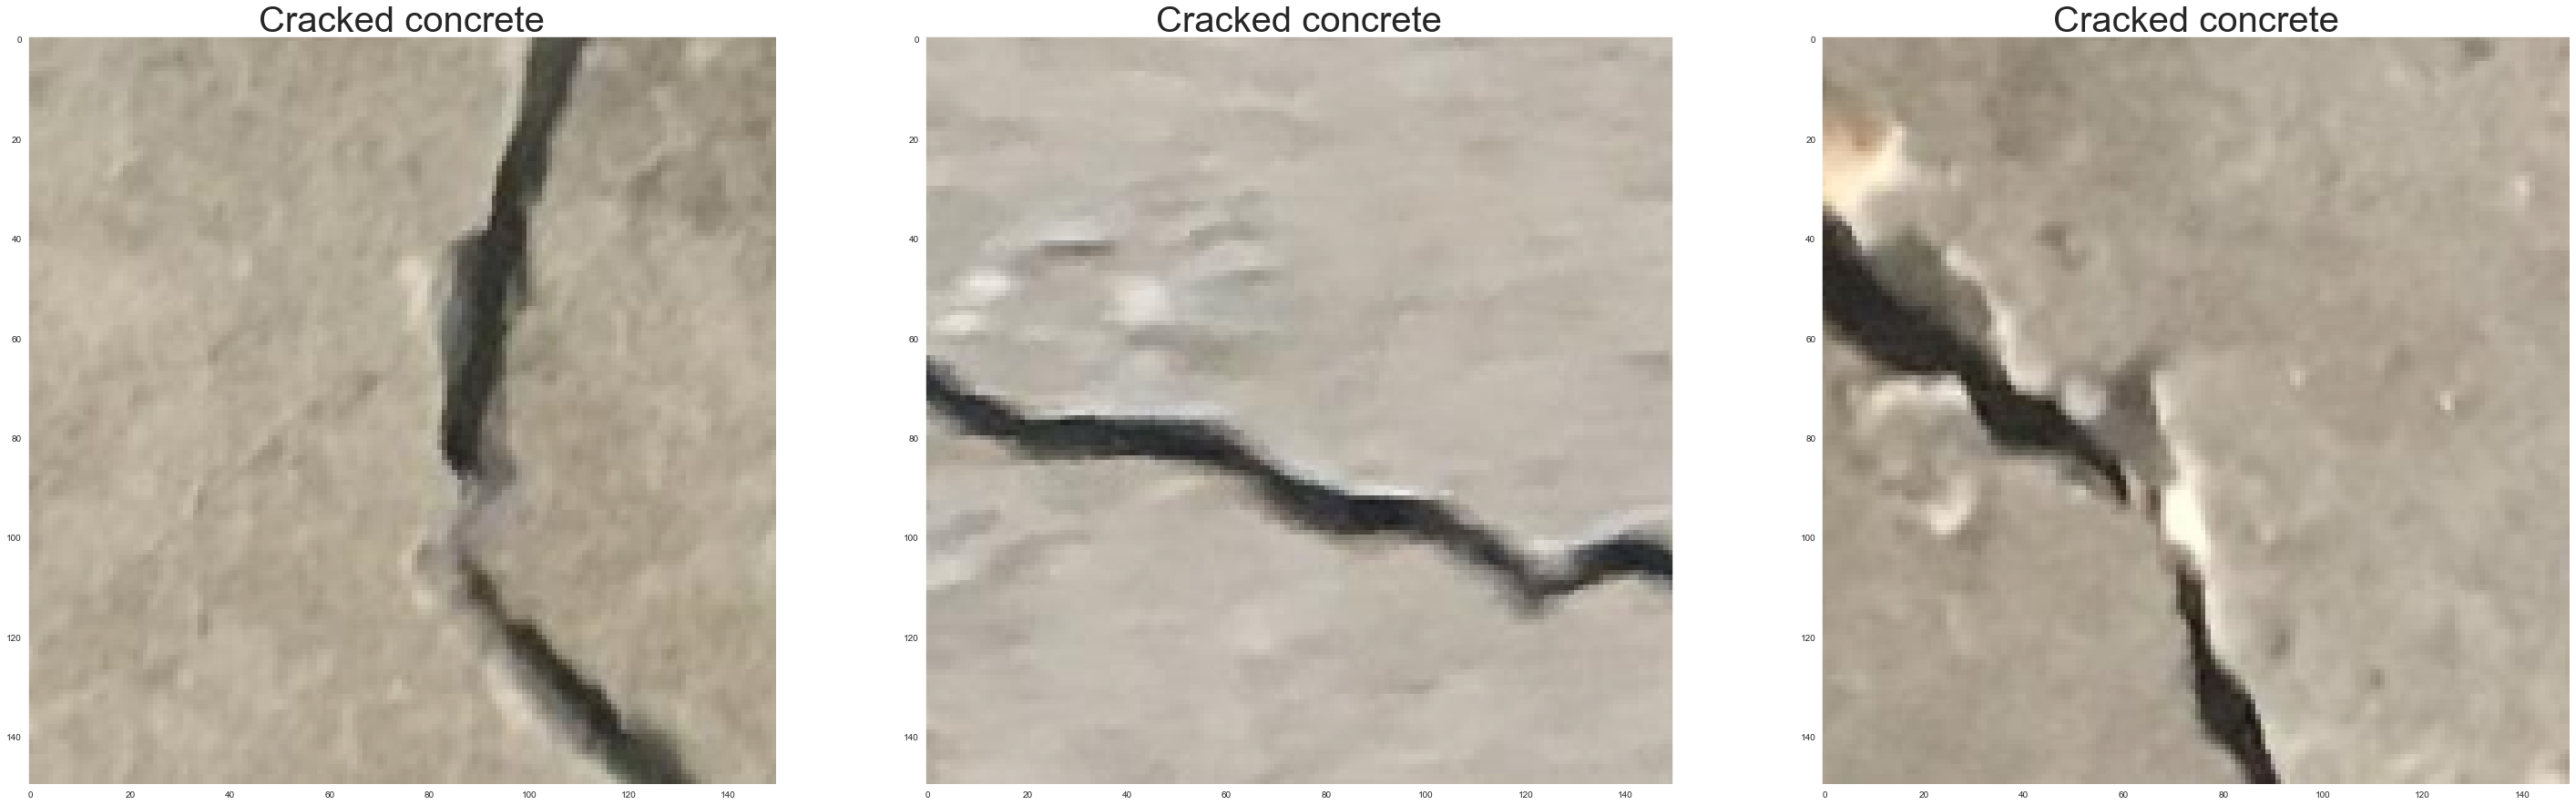

In [55]:
#Visualise some cracked samples
fig,ax =  plt.subplots(1,3)
fig.set_figheight(50)
fig.set_figwidth(50)
for i in range(3):
    ax[i].imshow(train[i][0])
    ax[i].set_title("Cracked concrete", fontsize=40)



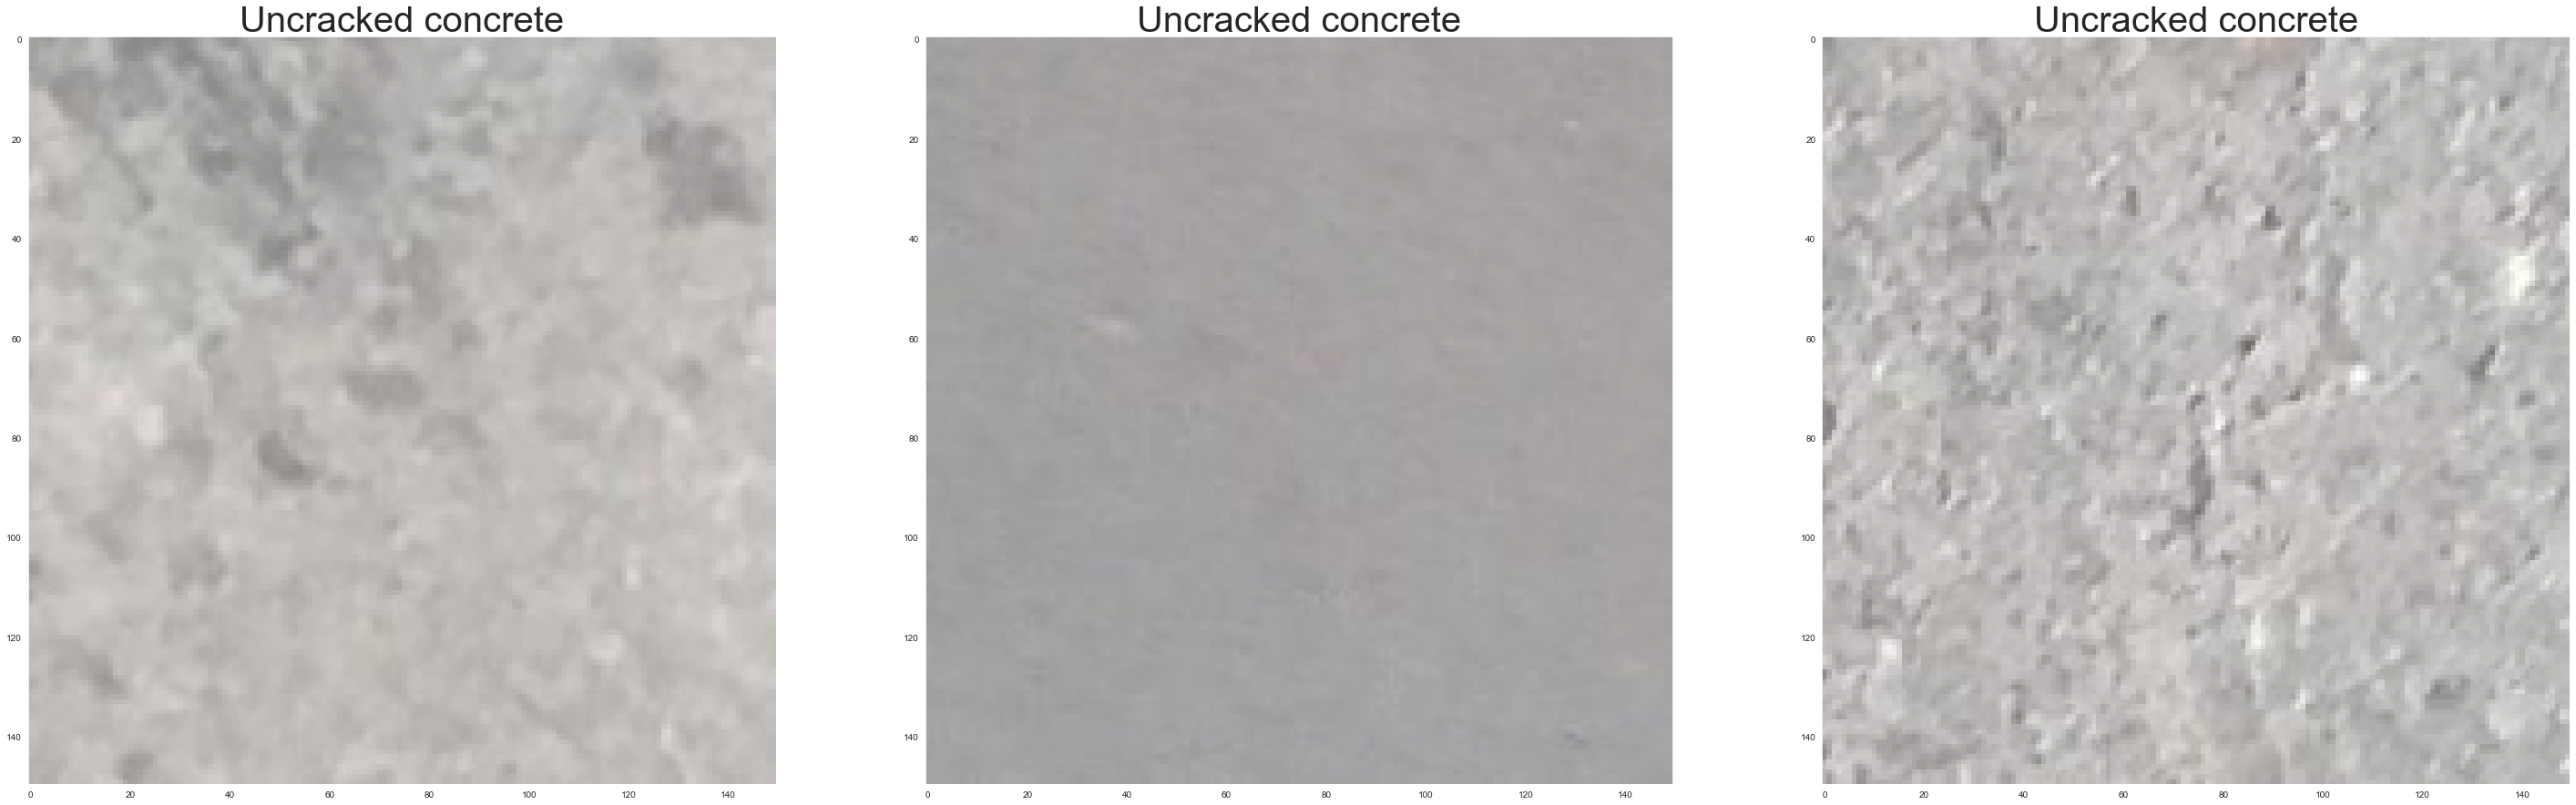

In [75]:
#Visualise some uncracked samples

fig,ax =  plt.subplots(1,3)
fig.set_figheight(50)
fig.set_figwidth(50)
for i in range(-3,0):
    ax[i].imshow(train[i][0])
    ax[i].set_title("Uncracked concrete", fontsize=40)


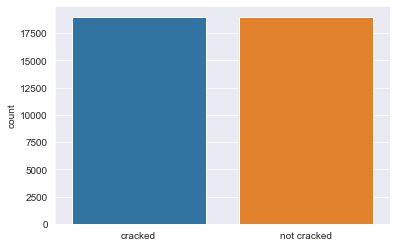

In [6]:
# countplot to check the balance of each class to ensure we don't have to deal with class imbalance issues
l = []
for i in train:
    if(i[1] == 0):
        l.append("cracked")
    else:
        l.append("not cracked")
sns.set_style('darkgrid')
sns.countplot(l)

In [7]:
#We next need to normalize the data (speeds up the training)
#and reshape all data to 150x150x1 3D matrices.
x_train = []
y_train = []
x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)
    
for feature, label in test_set:
    x_test.append(feature)
    y_test.append(label)

# Normalize the data
x_train = np.array(x_train) / 255
x_test = np.array(x_test) / 255

x_train.reshape(-1, img_size, img_size, 1)
x_test.reshape(-1, img_size, img_size, 1)

y_train = np.array(y_train)
y_test = np.array(y_test)



In [8]:
#we perform some data augmentation here 

datagen = ImageDataGenerator(
        featurewise_center=False,  
        samplewise_center=False,  
        featurewise_std_normalization=False,   
        samplewise_std_normalization=False,   
        zca_whitening=False,   
        rotation_range = 30,  # randomly rotate images by 30 deg
        zoom_range = 0.2, # randomly zoom image 20%
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images horizontally
        vertical_flip=False)  # randomly flip images vertically

datagen.fit(x_train)

## Model architecture

In [9]:
#the model is build here and the summary is printed at the end 

model = Sequential()
model.add(Conv2D(64,3,padding="same", activation="relu", input_shape = x_train.shape[1:]))
model.add(MaxPool2D())

model.add(Conv2D(64, 3, padding="same", activation="relu"))
model.add(MaxPool2D())

model.add(Conv2D(128, 3, padding="same", activation="relu"))
model.add(MaxPool2D())

model.add(Flatten())
model.add(Dense(256,activation="relu"))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(2, activation="softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 37, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 18, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 41472)             0

## Model training

In [10]:
# setting some callback parameters that will terminate training once some conditions are met. 
# these parameters may also adapt the learning rate if a plateau is reached
earlystop = EarlyStopping(monitor='val_accuracy', mode='max', patience=8,
                                              verbose=1, min_delta=0.0001, restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

callbacks = [earlystop, learning_rate_reduction]

opt = Adam(learning_rate=1e-5)
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(x_train, y_train, epochs = 15, callbacks=callbacks,validation_split = 0.2, verbose=1)

Epoch 1/15
950/950 [==============================] - 1556s 2s/step - loss: 0.1982 - accuracy: 0.9092 - val_loss: 0.0456 - val_accuracy: 0.9925
Epoch 2/15
950/950 [==============================] - 2075s 2s/step - loss: 0.0456 - accuracy: 0.9861 - val_loss: 0.0064 - val_accuracy: 0.9984
Epoch 3/15
950/950 [==============================] - 1551s 2s/step - loss: 0.0365 - accuracy: 0.9893 - val_loss: 0.0130 - val_accuracy: 0.9968
Epoch 4/15
950/950 [==============================] - 1821s 2s/step - loss: 0.0279 - accuracy: 0.9915 - val_loss: 0.0010 - val_accuracy: 1.0000
Epoch 5/15
950/950 [==============================] - 1488s 2s/step - loss: 0.0309 - accuracy: 0.9893 - val_loss: 0.0140 - val_accuracy: 0.9955
Epoch 6/15
950/950 [==============================] - 1939s 2s/step - loss: 0.0251 - accuracy: 0.9915 - val_loss: 7.9822 - val_accuracy: 0.0000e+00

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 7/15
950/950 [==============================]

## Model evaluation

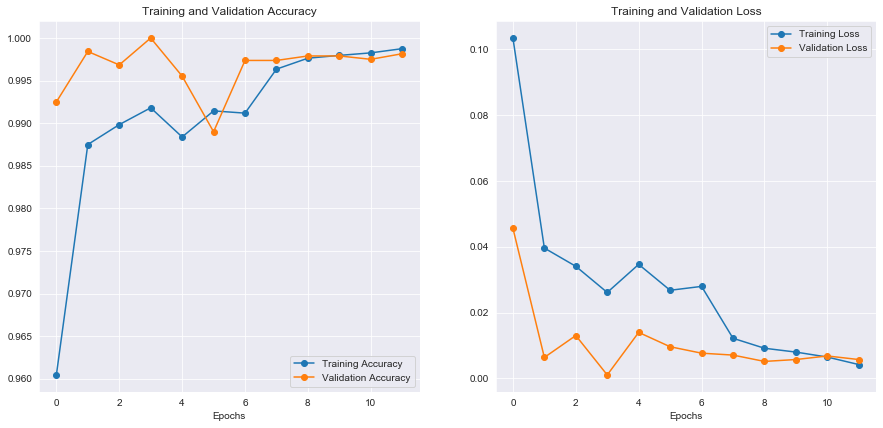

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(12)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy', marker='o')
plt.plot(epochs_range, val_acc, label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.legend(loc='lower right')


plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss', marker='o')
plt.plot(epochs_range, val_loss, label='Validation Loss', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.legend(loc='upper right')


plt.show()

In [1]:
#export model output so that it can be reused without having to run training again

model_json = model.to_json()
with open ("model.json",'w') as json_file:
    json_file.write(model_json)
    
model.save_weights('model.h5')
 

"""json_file = open('model.json','r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model=model_from_json(loaded_model_json)
loaded_model.load_weights('model.h5')
#use loaded_model.compile(...) and loaded_model.evaluate(...)""";

NameError: name 'model' is not defined

In [22]:
#time to evaluate  our model using the test set

predictions = model.predict(x_test)
predictions = predictions.reshape(1,-1)[0]
print(classification_report(y_test, predictions, target_names = ['Cracked (Class 0)','Not Cracked (Class 1)']))

                       precision    recall  f1-score   support

    Cracked (Class 0)       1.00      0.96      0.98      1000
Not Cracked (Class 1)       0.96      1.00      0.98      1000

             accuracy                           0.98      2000
            macro avg       0.98      0.98      0.98      2000
         weighted avg       0.98      0.98      0.98      2000



The trained model appears to have excellent performance metrics

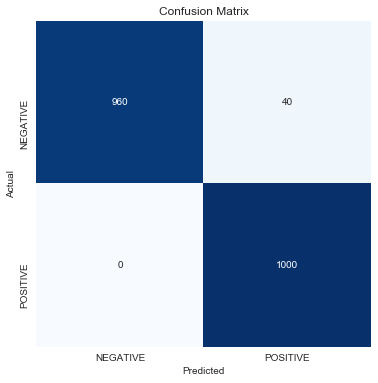

In [24]:
# plot the confusion matrix

cm=confusion_matrix(y_test, predictions)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks=np.arange(2) + 0.5, labels=["NEGATIVE", "POSITIVE"])
plt.yticks(ticks=np.arange(2) + 0.5, labels=["NEGATIVE", "POSITIVE"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

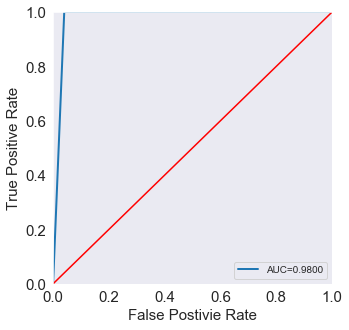

In [67]:
#AUC metric:

fig, ax = plt.subplots(figsize=(5, 5))
auc = roc_auc_score(y_test,predictions)

fpr, tpr, thresholds = roc_curve(y_test,predictions)   
ax.plot(fpr, tpr, linewidth = 2,label='AUC=%.4f' % auc)
ax.plot([0,1],[0,1], 'r')


ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_xlabel('False Postivie Rate',{'size':15})
ax.set_ylabel('True Positive Rate',{'size':15})

plt.tick_params(labelsize=15)

plt.legend()
plt.show()

Prediction: Not cracked


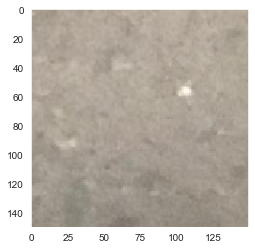

In [124]:
prediction=model.predict_classes(x_test)[-51]
if prediction==0:
    print('Prediction: Cracked')
else:
    print('Prediction: Not cracked')
imshow(test_set[-51][0]);

Prediction: Cracked


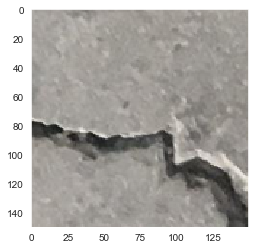

In [125]:
prediction=model.predict_classes(x_test)[51]
if prediction==0:
    print('Prediction: Cracked')
else:
    print('Prediction: Not cracked')
imshow(test_set[51][0]);

In [ ]:
#https://www.kaggle.com/zhangyunsheng/class-location
#https://www.kaggle.com/itokianarafidinarivo/tutorial-keras-image-classification
#https://www.analyticsvidhya.com/blog/2020/10/create-image-classification-model-python-keras/ 
#https://www.kaggle.com/zeynel7/detection-of-surface-crack-using-cnn